# Implementing the GNN

In [ ]:
import torch
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install tensorboardX
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

In [2]:
%pylab

# make plots show up in notebook
%matplotlib inline

import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

PARENT_DIR = 'gdrive/My Drive/Stat 175 Final Project/'

import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader, Data


import torch_geometric.transforms as T

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

Using matplotlib backend: <object object at 0x7fd847d2ad20>
Populating the interactive namespace from numpy and matplotlib
Mounted at /content/gdrive


In [3]:
# load data 
files = os.listdir(f'{PARENT_DIR}data')
data = [torch.load(f'{PARENT_DIR}data/{f}') for f in tqdm(files)]

100%|██████████| 413/413 [01:08<00:00,  6.02it/s]


In [4]:
# let first 300 for train and next 113 for test 
train_data = data[:300]
test_data = data[300:]

In [5]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(GNNStack, self).__init__()

        # initial embedding layer
        self.embed = nn.Sequential(
            nn.Linear(input_dim, embedding_dim), # squeeze NN
            nn.ReLU(),
            nn.Dropout(0.25), 
            nn.Linear(embedding_dim, input_dim),
            nn.ReLU(),
            nn.Dropout(0.25)
        )

        # GNN with 3 convolutional layers
        self.conv1 = pyg_nn.GCNConv(input_dim, hidden_dim)
        self.conv2 = pyg_nn.GCNConv(hidden_dim, hidden_dim)
        self.conv3 = pyg_nn.GCNConv(hidden_dim, hidden_dim)

        # https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_gnn.html

        # post-message-passing layers - output to single prediction
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))

        self.dropout = 0.25

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:  # ???
            x = torch.ones(data.num_nodes, 1)

        x = self.embed(x)  # linear layer
        x = self.conv1(x, edge_index) # GNN layers
        x = self.conv2(x, edge_index)  
        x = self.conv3(x, edge_index) 
        
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.post_mp(x)

        return x

    def loss(self, pred, truth):
      # mean squared error loss
      return F.mse_loss(pred, truth.unsqueeze(1))


def train(dataset, writer):
    # send to GPU 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # limit batch size to 16 for colab pro GPU / 32 for CPU as graph data is big!
    test_loader = loader = DataLoader(dataset, batch_size=16, shuffle=True)

    # build model and move it to GPU
    model = GNNStack(max(dataset[0].num_node_features, 1), 32, 32, 1).to(device)  # input_dim will be 150
    opt = optim.Adam(model.parameters(), lr=0.01)
    #return model

    # train
    losses = []
    model_history = []
    for epoch in range(500):
        total_loss = 0
        model.train()
        for batch in loader:
            # move data to GPU
            batch = batch.to(device)
            # backpropagate loss 
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        # update losses
        total_loss /= len(loader.dataset)
        losses.append(total_loss)
        writer.add_scalar("loss", total_loss, epoch)

        # save models to compute test loss later 
        model_history.append(model)

        if epoch % 20 == 0:
            print("Epoch {}. Loss: {:.4f}.".format(epoch, total_loss))
            torch.save(model, f'{PARENT_DIR}models/model_{epoch}.pt')

    return model, losses, model_history

In [6]:
%%time
# train model 
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

trial_train = train(train_data, writer)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0. Loss: 8921813537.0077.
Epoch 20. Loss: 8921482357.2133.
Epoch 40. Loss: 8921496540.4658.
Epoch 60. Loss: 8921394967.7208.
Epoch 80. Loss: 8921370962.5983.
Epoch 100. Loss: 8921365081.7600.
Epoch 120. Loss: 8921494106.0733.
Epoch 140. Loss: 8921183354.7400.
Epoch 160. Loss: 8921236757.4567.
Epoch 180. Loss: 8920948813.6533.
Epoch 200. Loss: 8920890856.2300.
Epoch 220. Loss: 8921002795.0600.
Epoch 240. Loss: 8921816417.4467.
Epoch 260. Loss: 8922009595.4400.
Epoch 280. Loss: 8920373418.8167.
Epoch 300. Loss: 8920712602.9067.
Epoch 320. Loss: 8921102278.5200.
Epoch 340. Loss: 8921029998.1667.
Epoch 360. Loss: 8920906931.4000.
Epoch 380. Loss: 8920468038.2000.
Epoch 400. Loss: 8918755149.7333.
Epoch 420. Loss: 8919884420.3450.
Epoch 440. Loss: 8921077161.5967.
Epoch 460. Loss: 8920534012.6467.
Epoch 480. Loss: 8920271366.0967.
CPU times: user 39min 58s, sys: 19min 2s, total: 59min 1s
Wall time: 59min 23s


In [7]:
torch.save(trial_train[0], f'{PARENT_DIR}GNN_500.pt')

In [9]:
loaded_model = torch.load(f'{PARENT_DIR}GNN_500.pt')
loaded_model # print architecture 

GNNStack(
  (embed): Sequential(
    (0): Linear(in_features=126, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=32, out_features=126, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
  )
  (conv1): GCNConv(126, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (post_mp): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Dropout(p=0.25, inplace=False)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [37]:
# get train loss 
np.mean([mean_squared_error(trial_train[0](dat.cuda()).detach().cpu().numpy(), dat.y.cpu().numpy()) for dat in train_data])
#trial_train[0](train_data[0].cuda())

8919660000.0

In [23]:
# get losses for all models 
from sklearn.metrics import mean_squared_error
test_losses_list = []
for model in trial_train[2]:
  l = np.mean([mean_squared_error(model(dat).detach().cpu().numpy(), dat.y.cpu().numpy()) for dat in test_data])
  test_losses_list.append(l)

In [33]:
# test loss is last model loss 
test_losses_list[-1]

74979320000.0

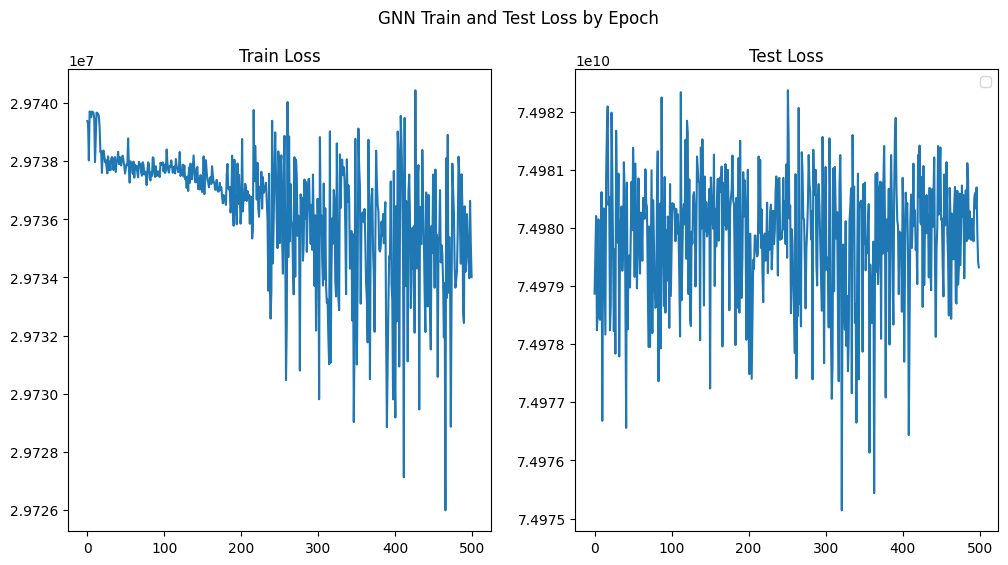

In [39]:
# plot loss curves 
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,2, figsize = (12, 6))
ax[0].plot(np.arange(0,len(trial_train[1])), np.array(trial_train[1])/300)
ax[1].plot(np.arange(0, len(test_losses_list)), np.array(test_losses_list))

ax[0].set_title("Train Loss")
ax[1].set_title("Test Loss")

plt.suptitle('GNN Train and Test Loss by Epoch')

plt.legend()
plt.savefig(f'{PARENT_DIR}plots/GNN_train_test_loss.png', dpi = 250)

In [25]:
# evaluate loss on a time window
def get_preds(dat, window, model = trial_train[0]):

  # get locations
  locations = pd.read_csv(f'{PARENT_DIR}locations.csv')[['lat','lon']]

  # add predictions and y data 
  locations['preds'] = model.forward(dat[window].cuda()).cpu().detach().numpy()
  locations['y'] = dat[window].y.cpu().detach()

  # compute loss
  loss_window = float(F.mse_loss(torch.tensor(locations['preds'].values), torch.tensor(locations['y'].values)))

  return locations, loss_window

In [40]:
# print which values have non-zero observations (more interesting for plotting)
for i in range(len(data)):
  if np.sum(data[i].y.numpy()) != 0:
    print(i)

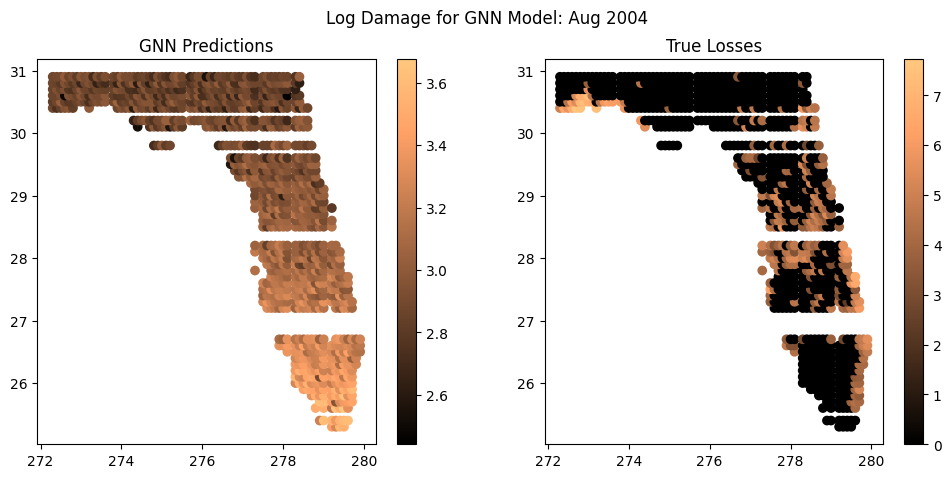

In [38]:
# plot side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# get data for window
data_plot = get_preds(test_data, 17)[0]

# plot predictions on left
sc1 = ax[0].scatter(data_plot.lon, data_plot.lat, c=np.log10(data_plot.preds+1), cmap=cm.copper)
cbar1 = fig.colorbar(sc1, ax=ax[0])
#cbar1.ax.set_title("Total Building Damage (Log)")
ax[0].set_title("GNN Predictions")

# plot actual loses on right
sc2 = ax[1].scatter(data_plot.lon, data_plot.lat, c=np.log10(data_plot.y+1), cmap=cm.copper)
cbar2= fig.colorbar(sc2, ax=ax[1])
ax[1].set_title("True Losses")
#cbar2.ax.set_title("Total Building Damage (Log)", rotation=90)
ax[0].annotate("Total Building Damage (log-10 scale)", xy = (.5, .5), rotation = 90)
plt.suptitle("Log Damage for GNN Model: Aug 2004")

plt.savefig(f'{PARENT_DIR}plots/aug_2004_gnn.png', dpi =250)